Min velocity: 1028.00  Max velocity 4500.00
dz,dx,dt (m): 4.0 4.0 0.000565685424949238
Model dimension [nz,nx,nt]:  201 601 1500
Time taken to create matrix A: 0.046 s


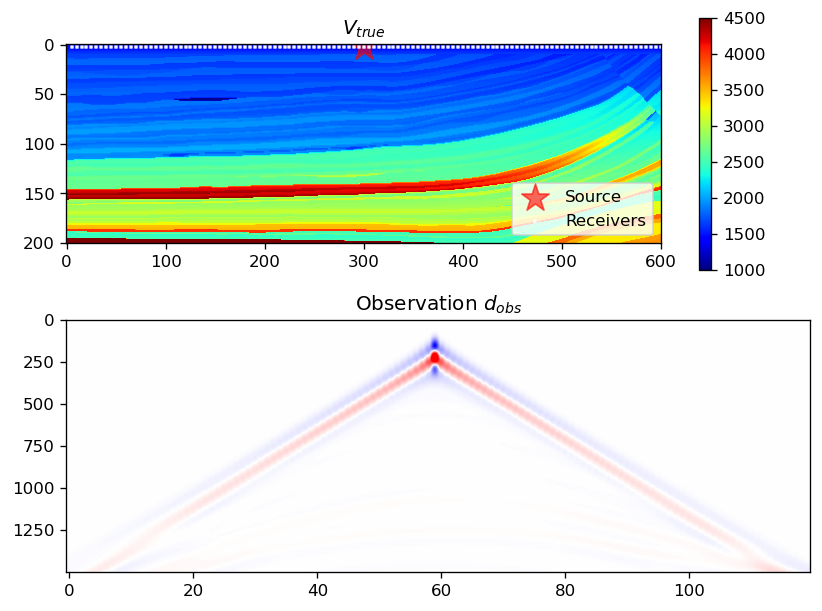

In [86]:
from IPython.display import clear_output
import numpy as np
import scipy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time
labelsize = 16

from func.propagation_matrix import defmodel, extend_model, second_order_derivative

precision = np.float64
device = 'cpu'

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v


def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(len(receivers_width), zxsrc[0]), receivers_width)) # Top
    # zxrec2 = np.vstack((np.full(len(receivers_width), nz-zxsrc[0]-1), receivers_width)) # Bottom
    # zxrec3 = np.vstack((receivers_height, np.full(len(receivers_height), zxsrc[0]))) # Left
    # zxrec4 = np.vstack((receivers_height, np.full(len(receivers_height), nx-zxsrc[0]-1))) # Right
    # zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
    zxrec = zxrec1

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec, indices = np.unique(zxrec,return_index=True,axis=1)

  return zxrec[:, np.argsort(indices)]


def extend_model(v,nz,nx,next):
	"""
	Extension of the model (to limit the edge effects)
	"""
	vel = v.reshape((nz,nx))
	nze  = nz + 2*next
	nxe  = nx + 2*next
	vele = np.zeros([nze,nxe], dtype=precision)
	# Central part
	vele[next:nze-next,next:nxe-next] = vel
	# Top and bottomB
	for ix in range(next,nxe-next):
		for iz in range(next):
			vele[iz,ix]       = vel[0,ix-next]
			vele[nze-1-iz,ix] = vel[nz-1,ix-next]
	# Left and right
	for ix in range(next):
		for iz in range(next,nze-next):
			vele[iz,ix]       = vel[iz-next,0]
			vele[iz,nxe-1-ix] = vel[iz-next,nx-1]
	# Corners
	for ix in range(next):
		for iz in range(next):
			vele[iz,ix]             = vel[0,0]
			vele[nze-1-iz,ix]       = vel[nz-1,0]
			vele[iz,nxe-1-ix]       = vel[0,nx-1]
			vele[nze-1-iz,nxe-1-ix] = vel[nz-1,nx-1]
	return vele.flatten()


def prop2d(wsrc, zxsrc, zxrec, vel, at, az, ax, next, device='cpu'):
	"""
	2d wave propagation with multiple sources
	"""
	
	if device=='cpu':
		"""
		2d wave propagation
		Resolution with finite differences
		Orders 2 in time and space
		with absorbing boundaries (Clayton and Engquist)
		Vectorial implementation (much faster)
		"""
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		nze = nz + 2 * next2
		nxe = nx + 2 * next2
		size = nze * nxe

		# Calculate source waveform
		wsrc = np.array([wsrc]) if wsrc.ndim == 1 else np.array(wsrc) # convert source wavelet from 1d to 2d
		zxsrc = np.array(zxsrc) # source location to array

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,nz,nx,next2)
		vele = vele.flatten()

		start = time.time()
		# Center Part (Laplacian)
		mask0 = np.full((nze, nxe), False)
		mask0[1+nabs:-1-nabs,1+nabs:-1-nabs] = True
		mask0 = mask0.flatten()

		# Construct the Laplacian matrix
		fact = (dt * vele)**2

		# Initialize arrays
		diagonal = np.zeros(size)
		off_diagonal_x_left = np.zeros(size)
		off_diagonal_x_right = np.zeros(size)
		off_diagonal_z_left = np.zeros(size)
		off_diagonal_z_right = np.zeros(size)

		# Set values for interior points
		diagonal[mask0] = (2*np.ones(size) + fact*(-2*np.ones(size)*(_dz2+_dx2)))[mask0]
		off_diagonal_x_left[mask0] = (fact*np.ones(size) * _dz2)[mask0]
		off_diagonal_x_right[mask0] = (fact*np.ones(size) * _dz2)[mask0]
		off_diagonal_z_left[mask0] = (fact*np.ones(size) * _dx2)[mask0]
		off_diagonal_z_right[mask0] = (fact*np.ones(size) * _dx2)[mask0]

		# Calculate factors for boundary conditions
		factz = (-dt/dz) * vele
		factx = (-dt/dx) * vele

		# Bottom part
		mask1 = np.full((nze, nxe), False)
		mask1[nze-1-nabs:nze,:nxe] = True
		mask1 = mask1.flatten()
		diagonal[mask1] = 1 + factz[mask1]
		off_diagonal_z_left[mask1] = -factz[mask1]

		# Top part
		mask2 = np.full((nze, nxe), False)
		mask2[:1+nabs,:nxe] = True
		mask2 = mask2.flatten()
		diagonal[mask2] = 1 + factz[mask2]
		off_diagonal_z_right[mask2] = -factz[mask2]

		# Right part
		mask3 = np.full((nze, nxe), False)
		mask3[:nze,nxe-1-nabs:nxe] = True
		mask3 = mask3.flatten()
		diagonal[mask3] = 1 + factx[mask3]
		off_diagonal_x_left[mask3] = -factx[mask3]

		# Left part
		mask4 = np.full((nze, nxe), False)
		mask4[:nze,:1+nabs]  = True
		mask4 = mask4.flatten()
		diagonal[mask4] = 1 + factx[mask4]
		off_diagonal_x_right[mask4] = -factx[mask4]

		# Construct the sparse Laplacian matrix
		A = sp.diags([off_diagonal_x_left[1:], off_diagonal_z_left[nxe:], diagonal, off_diagonal_z_right, off_diagonal_x_right],
								[-1, -nxe, 0, nxe, 1], shape=(size, size), format='csr')
		
		elapsed_time = time.time() - start
		print("Time taken to create matrix A: %.3f s" % elapsed_time)
		
		# Wavefield p mask (initial center part)
		maskp = np.full((nze, nxe), 0)
		maskp[next+nabs:nze-next-nabs,next+nabs:nxe-next-nabs]  = 1
		maskp = maskp.flatten()

		pm = np.zeros(size) # Previous wave field
		pt = np.zeros(size)
		pp = np.zeros(size)

		p = [np.zeros(nz*nx)]
		p.append(np.zeros(nz*nx))

		srcsteps = wsrc.shape[1] # Determine the time steps of the source
		for it in range(1,nt-1): # From 1 to nt-1
			pm = pt.copy()
			pt = pp.copy()
			# pp = A.dot(pt) - pm*mask0 + pwsrc[:,it]*fact*mask0
			if it<srcsteps:
				cen = np.zeros((nz,nx))
				cen[zxsrc[0,:], zxsrc[1,:]] = wsrc[:,it]
				asrcit = np.pad(cen, next2, mode='constant').flatten()
				srcterm = asrcit*fact*mask0
			else: srcterm = np.zeros(size)

			pp = A.dot(pt) - pm*mask0 + srcterm
			p.append(pp[maskp==1])

		p = np.moveaxis(np.array(p), 0, -1)
		d_obs = p.reshape((nz,nx,nt))[zxrec[0], zxrec[1], :]

	return p, d_obs

def second_order_derivative(p, at, az, ax):
	"""
	Calculate second order derivative for p(z,x,t)
	method: finite-difference
	"""
	# extend model to tmin=0 tmax=0 -- insert zeros in dimension t
	nz, nx = len(az), len(ax)
	dt = at[1] - at[0]
	# Modify p array in-place without copying
	p[:, 0] = 0.0
	p[:, -1] = 0.0
	_dt2 = 1./dt**2
	start = time.time()
	# Calculate second order derivative using vectorized operations
	p_dt_dt = (p[:, :-2] - 2 * p[:, 1:-1] + p[:, 2:]) * _dt2
	print(time.time()-start)
	# Insert zeros at boundaries using array views
	p_dt_dt = np.concatenate([np.zeros((nz*nx, 1)), p_dt_dt, np.zeros((nz*nx, 1))], axis=1)

	return p_dt_dt

def J(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	nz, nx = len(az), len(ax)
	if vel.ndim == 1: vel = np.reshape(vel.flatten(),(nz,nx))
	_, d = prop2d(wsrc,zxsrc,zxrec,vel,at,az,ax,next,device)
	residual = d - d_obs
	J = 0.5 * np.sum(residual ** 2) # Residual is the half of the L2 norm square
	print("J = %.2f" % J)

	return J

def gradiant(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	"""
	Calculate gradiant using adjoint state method
	"""
	p_fwd, d = prop2d(wsrc,zxsrc,zxrec,vel,at,az,ax,next,device)
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back, _ = prop2d(np.flip(residual,axis=1), zxrec, zxsrc, vel, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=1)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/vel**3  * np.sum(p_back * p_dt_dt, axis=1) # G.shape = (201,201)
	
	return G.flatten()

def readbin(flnam,nz,nx):
    # Read binary file (32 bits)
    with open(flnam,"rb") as fl:
        im = np.fromfile(fl, dtype=np.float32)
    im = im.reshape(nz,nx,order='F')
    return im

# Initialize the model axis az, ax, at
nz,nx,nt = 201,601,1500
vmin,vmax = 1000,4500
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

# Read the original input data
vel   = readbin('../dataset/marm2_sel.dat',nz,nx)
v_ref = vel * 1e3
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
receivers_height = np.arange(izsrc[0],nz-izsrc[0],interv) # down
zxrec = receiver_position(1)

p, d_obs = prop2d(wsrc,zxsrc,zxrec,v_ref.reshape(nz,nx),at,az,ax,next,device)

plt.figure(figsize=(8,6), dpi=120)
plt.subplot(2,1,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet')
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(2,1,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-5,vmax=5, aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

## Inversion

### Standard FWI

In [ ]:
from scipy.optimize import minimize

# optimize function
v_smo = readbin('../dataset/marm2_smo.dat',nz,nx)
v_init = (v_smo * 1e3).flatten()

def callback(x):
    clear_output(wait=True)
    v_fwi = x.reshape((nz, nx))
    plt.figure(figsize=(8,3), dpi=120)
    plt.imshow(v_fwi, vmin=vmin, vmax=vmax, cmap='jet')
    plt.colorbar()
    plt.title('Inversion Result')
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.axis('scaled')
    plt.show()

resi = minimize(fun = J, 
               x0 = v_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device),
               method='L-BFGS-B', 
               # method='Newton-CG',
               bounds = np.full((len(v_init), 2), (vmin,vmax)),
               jac = gradiant, # Jacobian
               options = {'disp':True, 'maxiter':50},
               callback = callback
              )
v_fwi = resi.x
print(v_fwi.shape)

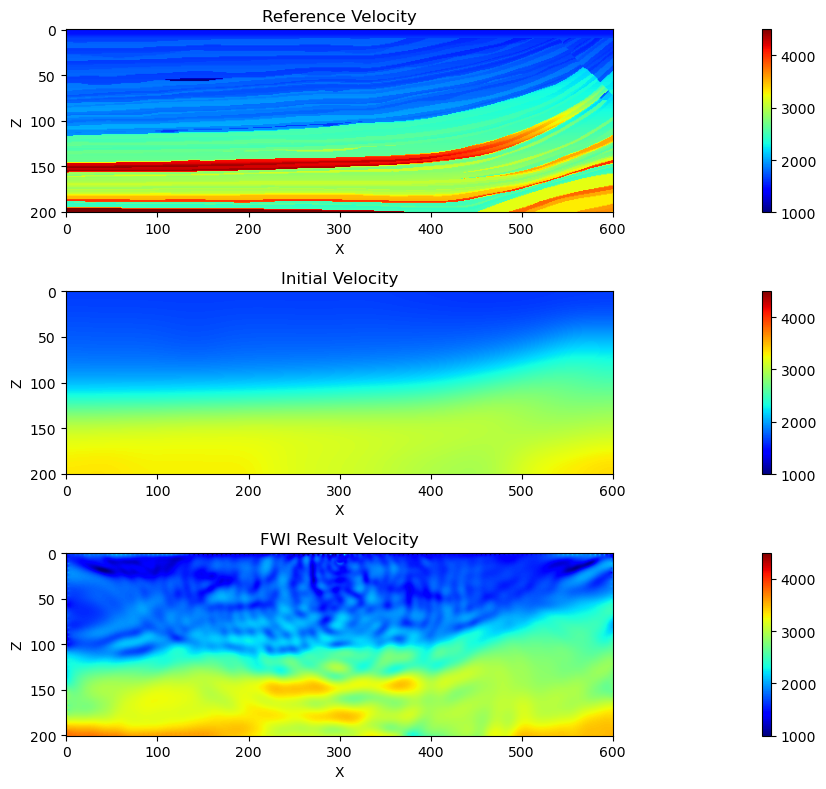

In [171]:
# Create the figure and subplots
plt.figure(figsize=(30, 8))

# Plot the reference velocity
plt.subplot(311)
plt.imshow(v_ref.reshape((nz, nx)), vmin=vmin, vmax=vmax, cmap='jet')
plt.colorbar()  # Adjust the pad value as needed
plt.title('Reference Velocity')
plt.xlabel('X')
plt.ylabel('Z')

# Plot the initial velocity
plt.subplot(312)
plt.imshow(v_init.reshape((nz, nx)), vmin=vmin, vmax=vmax, cmap='jet')
plt.colorbar()  # Adjust the pad value as needed
plt.title('Initial Velocity')
plt.xlabel('X')
plt.ylabel('Z')

# Plot the FWI result velocity
plt.subplot(313)
plt.imshow(v_fwi.reshape((nz, nx)), vmin=vmin, vmax=vmax, cmap='jet')
plt.colorbar()  # Adjust the pad value as needed
plt.title('FWI Result Velocity')
plt.xlabel('X')
plt.ylabel('Z')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### Prior term FWI

Loss (J) = 30717735.3492 Penalty term = 493375853.6536 Total loss = 524093589.0028 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       120801     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24094D+08    |proj g|=  2.82204D+03
Loss (J) = 16592368.0959 Penalty term = 418445381968.3055 Total loss = 418461974336.4014 
Loss (J) = 30368733.5619 Penalty term = 291683304.2995 Total loss = 322052037.8615 

At iterate    1    f=  3.22052D+08    |proj g|=  2.86412D+03
Loss (J) = 30376377.1945 Penalty term = 118450196.3207 Total loss = 148826573.5152 

At iterate    2    f=  1.48827D+08    |proj g|=  2.76426D+03
Loss (J) = 30342951.4568 Penalty term = 77146192.0340 Total loss = 107489143.4908 

At iterate    3    f=  1.07489D+08    |proj g|=  2.73948D+03
Loss (J) = 30248789.7690 Penalty term = 52723604.4482 Total loss = 82972394.2172 

At iterate    4    f=  8.29724D+07    |proj g|=  2.64239D+03
Loss (J) = 30070

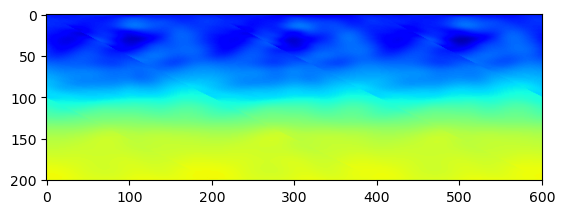

In [186]:
from func.velocity_model import gaussian2d

def J_prior(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	nz, nx = len(az), len(ax)
	if vel.ndim == 1: vel = np.reshape(vel.flatten(),(nz,nx))
	_, d = prop2d(wsrc,zxsrc,zxrec,vel,at,az,ax,next,device)
	residual = d - d_obs
	loss_J = 0.5 * np.sum(residual ** 2) / alpha # Residual is the half of the L2 norm square
	print("Loss (J) = %.4f " % loss_J, end='')
	vel = vel.flatten()
	# penalty = .5 * vel.T.dot(Q.toarray()).dot(vel)
	penalty = 0.5 * vel.T.dot(Q.dot(vel))
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = loss_J + penalty
	print("Total loss = %.4f " % loss)
	# Save history
	global current_loss
	current_loss = np.array([loss,loss_J,penalty])

	return loss

def gradiant_prior(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	nz, nx, nt = len(az), len(ax), len(at)
	# if vel.ndim == 1: vel = np.reshape(vel,(nz,nx))
	p_fwd, d = prop2d(wsrc,zxsrc,zxrec,vel,at,az,ax,next,device)
	receiver_depth = zxrec[0]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back, _ = prop2d(np.flip(residual,axis=1), zxrec, zxsrc, vel, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=1)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/vel**3  * np.sum(p_back * p_dt_dt, axis=1) # G.shape = (201,201)

	return G.flatten()/ alpha + Q.dot(vel.flatten())

# Record loss history over each iterations
def callback(xk):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])
	
# minimize cost function
_, Q = gaussian2d(ranges = [500,50], param=1.,nx=[201,601], variance=500, mean=2500)
v_smo = readbin('../dataset/marm2_smo.dat',nz,nx)
v_init = (v_smo * 1e3).flatten()
loss_tracker = np.empty((0,3))

std_noise = 0.01 # define the noise level
alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

resi = minimize(fun = J_prior, 
               x0 = v_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha),
               method='L-BFGS-B', 
               # method='Newton-CG',
               bounds = np.full((len(v_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant_prior,
               options = {'disp':True, 'maxiter':500},
               callback=callback
              )
v_fwi = resi.x

plt.imshow(v_fwi.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet')

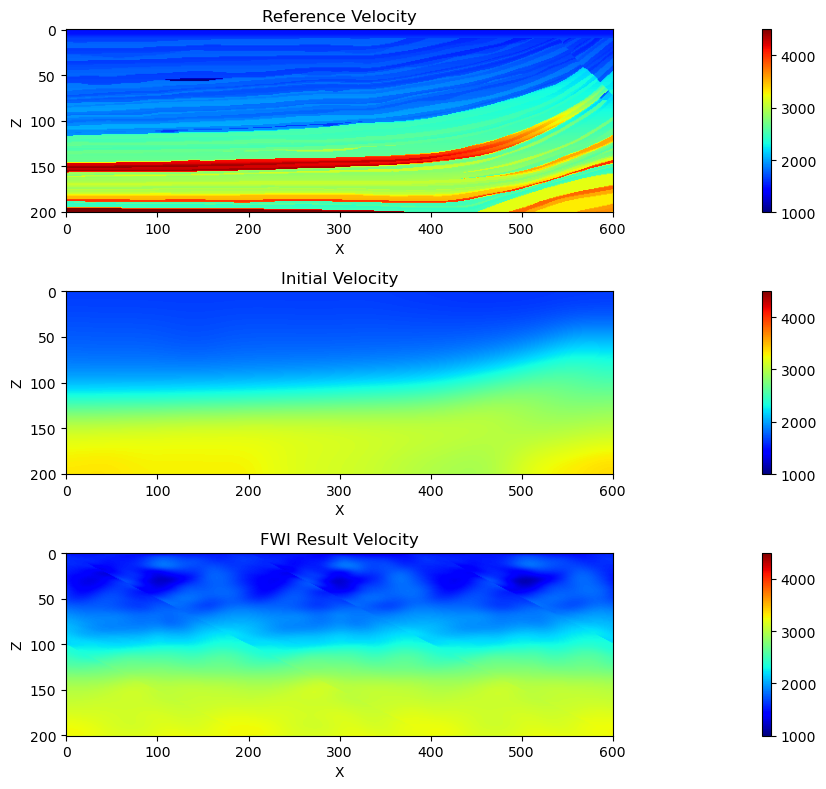

In [187]:
# Create the figure and subplots
plt.figure(figsize=(30, 8))

# Plot the reference velocity
plt.subplot(311)
plt.imshow(v_ref.reshape((nz, nx)), vmin=vmin, vmax=vmax, cmap='jet')
plt.colorbar()  # Adjust the pad value as needed
plt.title('Reference Velocity')
plt.xlabel('X')
plt.ylabel('Z')

# Plot the initial velocity
plt.subplot(312)
plt.imshow(v_init.reshape((nz, nx)), vmin=vmin, vmax=vmax, cmap='jet')
plt.colorbar()  # Adjust the pad value as needed
plt.title('Initial Velocity')
plt.xlabel('X')
plt.ylabel('Z')

# Plot the FWI result velocity
plt.subplot(313)
plt.imshow(v_fwi.reshape((nz, nx)), vmin=vmin, vmax=vmax, cmap='jet')
plt.colorbar()  # Adjust the pad value as needed
plt.title('FWI Result Velocity')
plt.xlabel('X')
plt.ylabel('Z')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### 100x300

Min velocity: 2000.00  Max velocity 3500.00
dz,dx,dt (m): 4.0 4.0 0.0006363961030678928
Model dimension [nz,nx,nt]:  100 300 500
Time to create A used: 0.2516164779663086 s


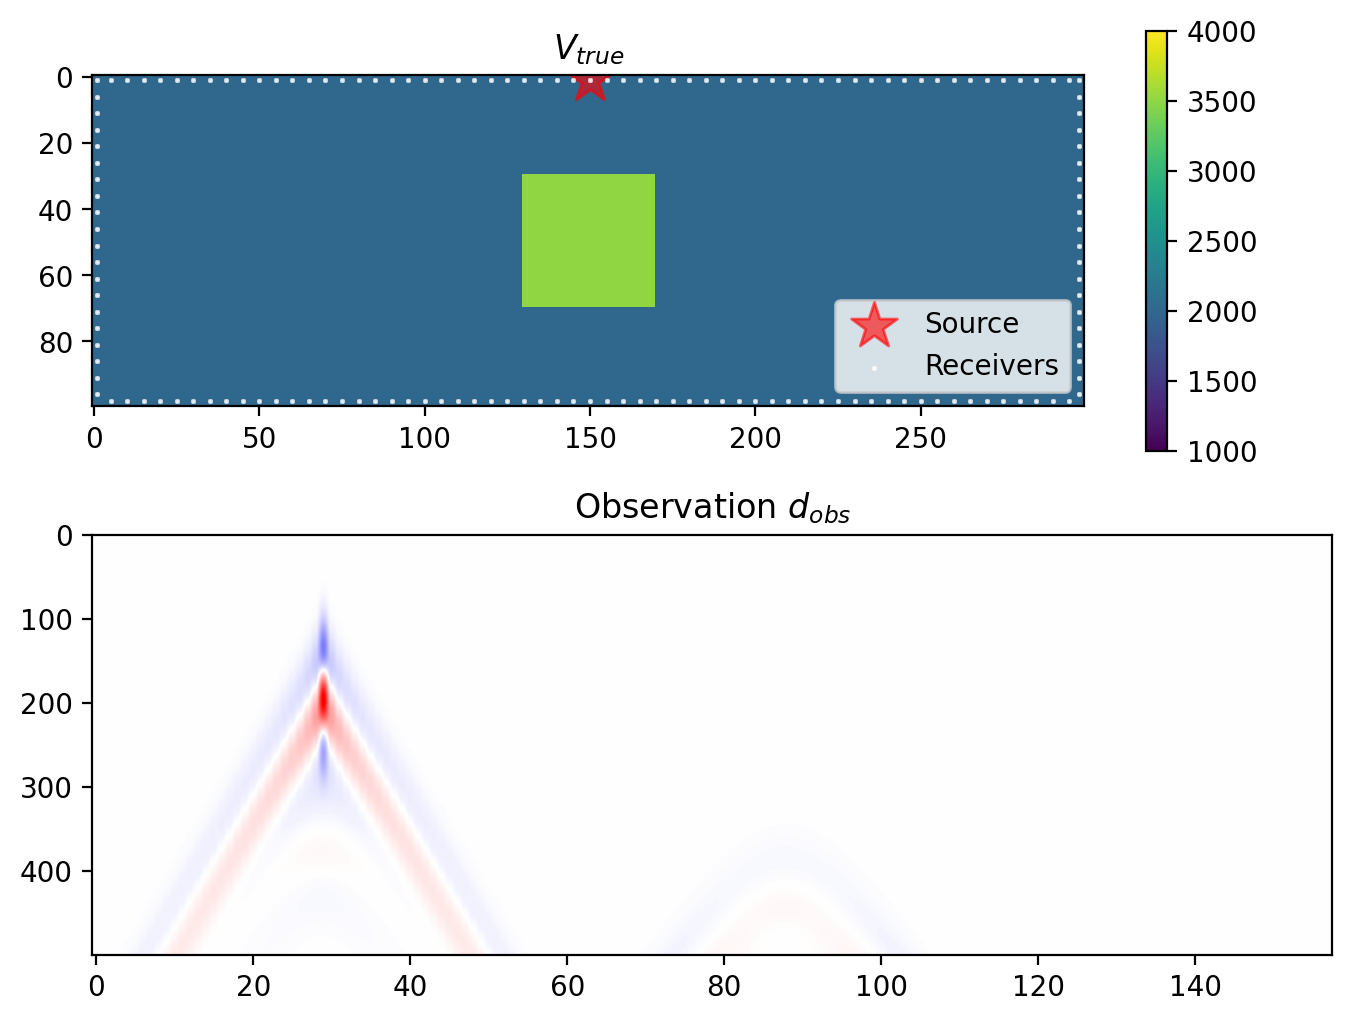

In [113]:
# Create a new velocity field
nz,nx,nt = 100,300,500
vmin,vmax = 1000,4000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100
ve= np.ones((100, 300)) * 2000
ve[30:70, 130:170] = 3500
v_ref = ve

print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
receivers_height = np.arange(izsrc[0],nz-izsrc[0],interv) # down
zxrec = receiver_position(1)

p, d_obs = prop2d(wsrc,zxsrc,zxrec,v_ref.reshape(nz,nx),at,az,ax,next,device)


plt.figure(figsize=(8,6), dpi=200)
plt.subplot(2,1,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=1000,vmax=4000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(2,1,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10, aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

Time to create A used: 0.23414397239685059 s
J = 271.09991237301347
Time to create A used: 0.22052979469299316 s
Time to create A used: 0.21679186820983887 s
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        30000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71100D+02    |proj g|=  4.31268D-03
Time to create A used: 0.27738261222839355 s
J = 271.099508782152
Time to create A used: 0.213667631149292 s
Time to create A used: 0.21286416053771973 s

At iterate    1    f=  2.71100D+02    |proj g|=  4.31262D-03
Time to create A used: 0.2563321590423584 s
J = 199.13944892603817
Time to create A used: 0.2094881534576416 s
Time to create A used: 0.2149503231048584 s

At iterate    2    f=  1.99139D+02    |proj g|=  1.12903D-03
Time to create A used: 0.2706718444824219 s
J = 123.28252133453617
Time to create A used: 0.211653470993042 s
Time to create A used: 0.21268272399902344 s

At iterate    3    f=  1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Time to create A used: 0.2714085578918457 s
J = 33.64206795501293
Time to create A used: 0.216569185256958 s
Time to create A used: 0.2153644561767578 s
Time to create A used: 0.25139713287353516 s
J = 33.64161785253244
Time to create A used: 0.21985769271850586 s
Time to create A used: 0.2121109962463379 s
Time to create A used: 0.26865720748901367 s
J = 33.63981761628795
Time to create A used: 0.20800280570983887 s
Time to create A used: 0.20936274528503418 s
Time to create A used: 0.26314592361450195 s
J = 33.63261945039569
Time to create A used: 0.22027254104614258 s
Time to create A used: 0.21182608604431152 s
Time to create A used: 0.26441144943237305 s
J = 33.603871264018686
Time to create A used: 0.21219468116760254 s
Time to create A used: 0.20744037628173828 s
Time to create A used: 0.24309587478637695 s
J = 33.48959091242566
Time to create A used: 0.2108302116394043 s
Time to create A used: 0.21006059646606445 s
Time to create A used: 0.25022149085998535 s
J = 33.04391655704

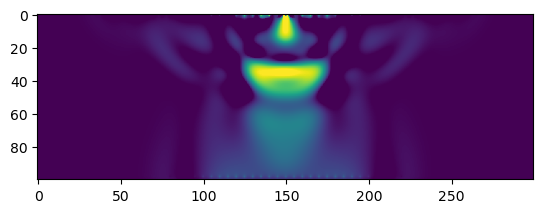

In [114]:
from scipy.optimize import minimize

# optimize cost function
v_init = np.zeros([nz*nx]) + 2000   # Initial v

resi = minimize(fun = J, 
               x0 = v_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device),
               method='L-BFGS-B', 
               # method='Newton-CG',
               bounds = np.full((len(v_init), 2), (vmin,vmax)),
               jac = gradiant, # Jacobian
               options = {'disp':True, 'maxiter':30},
              )
v_fwi = resi.x
print(v_fwi.shape)
plt.imshow(v_fwi.reshape((nz,nx)),vmin=2000,vmax=3000)

# Test code

### Sparse matrix structure

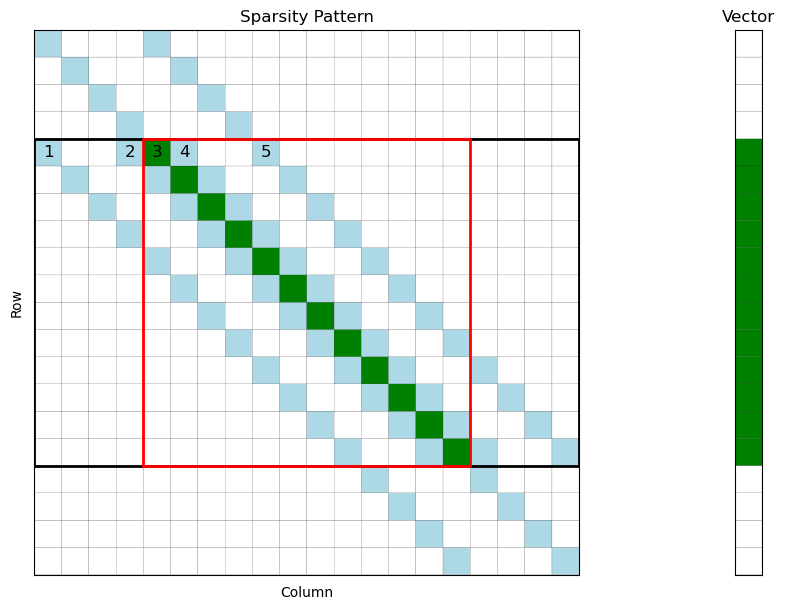

In [174]:
from matplotlib import pyplot as plt
from matplotlib import colors

d = 4
bdr = 2
d2 = d**2
dd = d2 + 2*bdr
structure = sc.sparse.diags([np.ones(dd), np.ones(dd), 2*np.ones(dd), np.ones(dd), np.ones(dd)],offsets=[-d,-1,0,1,d],shape=(dd,dd),format='csr')

upper = sp.diags([np.ones(d), np.ones(d)],offsets=[0, d],shape=(d,dd),format='csr')
lower = sp.diags([np.ones(d), np.ones(d)],offsets=[dd-d, dd-d-2*bdr],shape=(d,dd),format='csr')

# Define the indices of the left and right parts in the sparse matrix
left_indices = slice(bdr, dd-bdr)  # Specify the range of row indices for the left part
right_indices = slice(bdr, dd-bdr)  # Specify the range of row indices for the right part

structure[np.arange(d),:] = upper
structure[np.arange(dd-d,dd),:] = lower

structure = structure.toarray()



cmap = colors.ListedColormap(['white','lightblue','g'])
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
plt.pcolor(structure[::-1],cmap=cmap, edgecolors='k', linewidths=0.1)
plt.gca().set_aspect('equal')

plt.text(.5, dd+.5-5, '1', ha='center', va='center', color='k', fontsize=12)
plt.text(3.5, dd+.5-5, '2', ha='center', va='center', color='k', fontsize=12)
plt.text(4.5, dd+.5-5, '3', ha='center', va='center', color='k', fontsize=12)
plt.text(5.5, dd+.5-5, '4', ha='center', va='center', color='k', fontsize=12)
plt.text(8.5, dd+.5-5, '5', ha='center', va='center', color='k', fontsize=12)

# Highlight the edges of the center 16x16 grid
plt.plot([0, dd, dd, 0, 0], [d, d, d2, d2, 4], 'k-', linewidth=2)
plt.plot([d, d2, d2, d, d], [d, d, d2, d2, 4], 'r-', linewidth=2)
plt.title('Sparsity Pattern')
plt.xticks([])
plt.yticks([])
plt.xlabel('Column')
plt.ylabel('Row')



plt.subplot(1, 2, 2)
vector = np.zeros((dd, 1))
vector[d:-d] = 1
plt.pcolor(vector,cmap=cmap, edgecolors='k', linewidths=0.1)
plt.gca().set_aspect('equal')
# plt.plot([0, 1, 1, 0, 0], [d, d, d2, d2, d], 'r-', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.title('Vector')

plt.tight_layout()
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		# Calculate source waveform
		wsrc = np.array([wsrc], dtype=precision) if wsrc.ndim == 1 else np.array(wsrc) # convert source wavelet from 1d to 2d
		zxsrc = np.array(zxsrc) # source location to array
		pwsrc = np.zeros([nz, nx, nt]) # creat a initial p with zeros
		pwsrc[zxsrc[0,:], zxsrc[1,:], :wsrc.shape[1]] = wsrc # insert source wavelet

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,next2)

		# Shift the source by next
		asrc = np.zeros([nze-2*nabs-2,nxe-2*nabs-2])
		pm    = np.zeros([nze,nxe]) # Previous wave field
		pt    = np.zeros([nze,nxe])
		pp    = np.zeros([nze,nxe])
		fact = (dt * vele[nabs:-nabs,nabs:-nabs])**2plt.show()

## New code - A

Min velocity: 2006.27  Max velocity 2998.51
dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 1200
Time to create A used: 0.017887592315673828 s
Time to create A used: 0.024648189544677734 s
Time to create A used: 0.20130181312561035 s
141
(1, 141)


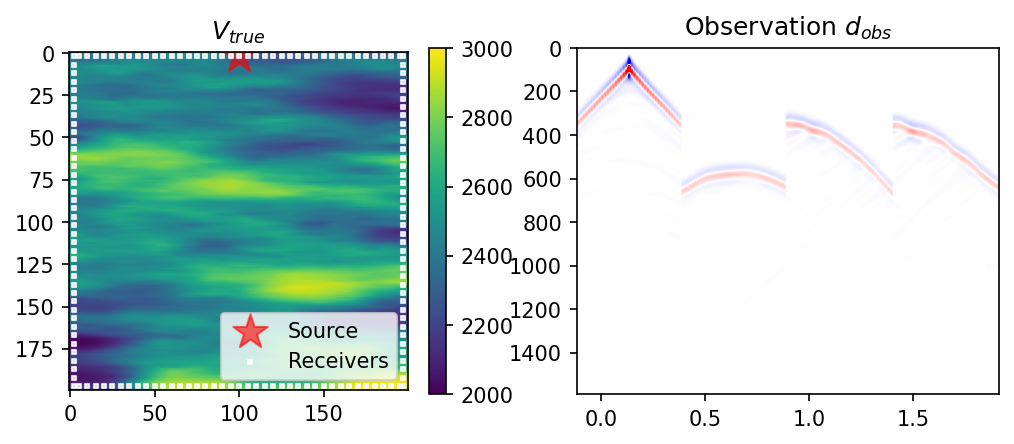

In [75]:
from IPython.display import clear_output
import numpy as np
import scipy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time
labelsize = 16

from func.propagation_matrix import defmodel, J, second_order_derivative

precision = np.float64
device = 'cpu'

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v


def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(len(receivers_width), zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(len(receivers_width), nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_height, np.full(len(receivers_height), zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_height, np.full(len(receivers_height), nx-zxsrc[0]-1))) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec, indices = np.unique(zxrec,return_index=True,axis=1)

  return zxrec[:, np.argsort(indices)]

def extend_model(vel,next):
	"""
	Extension of the model (to limit the edge effects)
	"""
	nz   = np.shape(vel)[0]
	nx   = np.shape(vel)[1]
	nze  = nz + 2*next
	nxe  = nx + 2*next
	vele = np.zeros([nze,nxe])
	# Central part
	vele[next:nze-next,next:nxe-next] = vel
	# Top and bottomB
	for ix in range(next,nxe-next):
		for iz in range(next):
			vele[iz,ix]       = vel[0,ix-next]
			vele[nze-1-iz,ix] = vel[nz-1,ix-next]
	# Left and right
	for ix in range(next):
		for iz in range(next,nze-next):
			vele[iz,ix]       = vel[iz-next,0]
			vele[iz,nxe-1-ix] = vel[iz-next,nx-1]
	# Corners
	for ix in range(next):
		for iz in range(next):
			vele[iz,ix]             = vel[0,0]
			vele[nze-1-iz,ix]       = vel[nz-1,0]
			vele[iz,nxe-1-ix]       = vel[0,nx-1]
			vele[nze-1-iz,nxe-1-ix] = vel[nz-1,nx-1]
	return vele

def prop2d(wsrc, zxsrc, zxrec, vel, at, az, ax, next, device='cpu'):
	"""
	2d wave propagation with multiple sources
	"""
	
	if device=='cpu':
		start = time.time()
		"""
		2d wave propagation
		Resolution with finite differences
		Orders 2 in time and space
		with absorbing boundaries (Clayton and Engquist)
		Vectorial implementation (much faster)
		"""
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		nze = nz + 2 * next2
		nxe = nx + 2 * next2
		size = nze * nxe


		# Calculate source waveform
		wsrc = np.array([wsrc]) if wsrc.ndim == 1 else np.array(wsrc) # convert source wavelet from 1d to 2d
		zxsrc = np.array(zxsrc) # source location to array

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,next2)
		vele = vele.flatten()

		# Center Part (Laplacian)
		mask0 = np.full((nze, nxe), 0)
		mask0[1+nabs:-1-nabs,1+nabs:-1-nabs] = 1
		mask0 = mask0.flatten()

		# Construct the Laplacian matrix
		fact = (dt * vele)**2
		
		diagonal = -2*np.ones(size)*(_dz2+_dx2)
		off_diagonal_x = np.ones(size) * _dz2
		off_diagonal_z = np.ones(size) * _dx2
		print('Time to create A used:',time.time() - start, 's')
		start = time.time()
		A = sp.diags([off_diagonal_x, off_diagonal_z, diagonal, off_diagonal_z, off_diagonal_x],
										[-1, -nxe, 0, nxe, 1], shape=(size, size), format = 'csr')
		A = sp.diags(fact*mask0, 0, format='csr').dot(A) + sp.diags(2*np.ones(size)*mask0, 0, format='csr')

		print('Time to create A used:',time.time() - start, 's')
		start = time.time()
		factz = (-dt/dz) * vele
		factx = (-dt/dx) * vele
		# Bottom part
		mask1 = np.full((nze, nxe), 0)
		mask1[nze-1-nabs:nze,:nxe] = 1
		mask1 = mask1.flatten()

		A[np.where(mask1==1)[0],np.where(mask1==1)[0]] = 1 + factz[mask1==1]
		A[np.where(mask1==1)[0],np.where(mask1==1)[0]-nxe] = -factz[mask1==1]

		# Top part
		mask2 = np.full((nze, nxe), 0)
		mask2[:1+nabs,:nxe] = 1
		mask2 = mask2.flatten()

		A[np.where(mask2==1)[0],np.where(mask2==1)[0]] = 1 + factz[mask2==1]
		A[np.where(mask2==1)[0],np.where(mask2==1)[0]+nxe] = -factz[mask2==1]

		# Right part
		mask3 = np.full((nze, nxe), 0)
		mask3[:nze,nxe-1-nabs:nxe] = 1
		mask3 = mask3.flatten()

		A[np.where(mask3==1)[0],np.where(mask3==1)[0]] = 1 + factx[mask3==1]
		A[np.where(mask3==1)[0],np.where(mask3==1)[0]-1] = -factx[mask3==1]

		# Left part
		mask4 = np.full((nze, nxe), 0)
		mask4[:nze,:1+nabs]  = 1
		mask4 = mask4.flatten()

		A[np.where(mask4==1)[0],np.where(mask4==1)[0]] = 1 + factx[mask4==1]
		A[np.where(mask4==1)[0],np.where(mask4==1)[0]+1] = -factx[mask4==1]

		A = A.tocsr()
		# Wavefield p mask (the very center part)
		maskp = np.full((nze, nxe), 0)
		maskp[next+nabs:nze-next-nabs,next+nabs:nxe-next-nabs]  = 1
		maskp = maskp.flatten()

		pm = np.zeros(size) # Previous wave field
		pt = np.zeros(size)
		pp = np.zeros(size)

		p = [np.zeros(nz*nx)]
		p.append(np.zeros(nz*nx))

		print('Time to create A used:',time.time() - start, 's')

		srclen = wsrc.shape[1] # Determine the time lenth of the source
		print(srclen)
		print(wsrc.shape)
		for it in range(1,nt-1): # From 1 to nt-1
			pm = pt.copy()
			pt = pp.copy()
			# pp = A.dot(pt) - pm*mask0 + pwsrc[:,it]*fact*mask0
			if it<srclen:
				cen = np.zeros((nz,nx))
				cen[zxsrc[0,:], zxsrc[1,:]] = wsrc[:,it]
				asrcit = np.pad(cen, next2, mode='constant').flatten()
				srcterm = asrcit*fact*mask0
			else: srcterm = np.zeros(size)

			pp = A.dot(pt) - pm*mask0 + srcterm
			p.append(pp[maskp==1])

		p = np.moveaxis(np.array(p), 0, -1)
		d_obs = p.reshape((nz,nx,nt))[zxrec[0], zxrec[1], :]

	return p, d_obs


import pickle
# load data
filename = './data/u_200'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_200'
infile = open(filename, 'rb')
Q = pickle.load(infile).astype('float32')
Q.astype('float32')
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,1200
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

# u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers

receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
receivers_height = np.arange(izsrc[0],nz-izsrc[0],interv) # down

zxrec = receiver_position(1)

p, d_obs = prop2d(wsrc,zxsrc,zxrec,v_ref.reshape(nz,nx),at,az,ax,next,device)

plt.figure(figsize=(8,3),dpi=150)
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

In [ ]:
import time

for i in range(50):
  clear_output(wait=True)
  iter = 1200//50 * i
  lim = 4
  plt.figure()
  plt.imshow(p[:,iter].reshape((nz,nx)),cmap='bwr',vmin=-lim, vmax=lim)
  plt.colorbar()
  plt.show()
  time.sleep(0.2)

### Code for diagonal once

Min velocity: 1028.00  Max velocity 4500.00
dz,dx,dt (m): 4.0 4.0 0.000565685424949238
Model dimension [nz,nx,nt]:  201 601 1500
0.035151004791259766


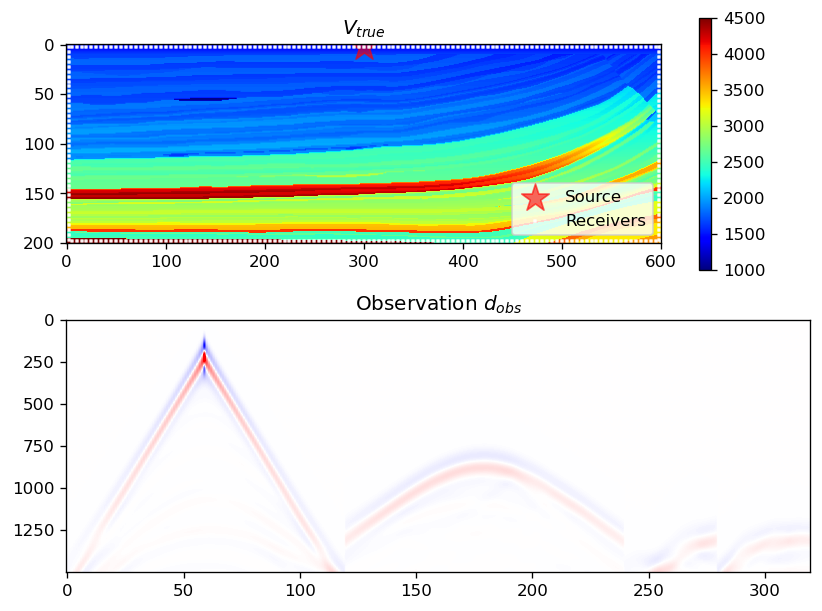

In [36]:
from IPython.display import clear_output
import numpy as np
import scipy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time
labelsize = 16

from func.propagation_matrix import defmodel, extend_model, second_order_derivative

precision = np.float64
device = 'cpu'

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v


def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(len(receivers_width), zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(len(receivers_width), nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_height, np.full(len(receivers_height), zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_height, np.full(len(receivers_height), nx-zxsrc[0]-1))) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec, indices = np.unique(zxrec,return_index=True,axis=1)

  return zxrec[:, np.argsort(indices)]


def extend_model(v,nz,nx,next):
	"""
	Extension of the model (to limit the edge effects)
	"""
	vel = v.reshape((nz,nx))
	nze  = nz + 2*next
	nxe  = nx + 2*next
	vele = np.zeros([nze,nxe], dtype=precision)
	# Central part
	vele[next:nze-next,next:nxe-next] = vel
	# Top and bottomB
	for ix in range(next,nxe-next):
		for iz in range(next):
			vele[iz,ix]       = vel[0,ix-next]
			vele[nze-1-iz,ix] = vel[nz-1,ix-next]
	# Left and right
	for ix in range(next):
		for iz in range(next,nze-next):
			vele[iz,ix]       = vel[iz-next,0]
			vele[iz,nxe-1-ix] = vel[iz-next,nx-1]
	# Corners
	for ix in range(next):
		for iz in range(next):
			vele[iz,ix]             = vel[0,0]
			vele[nze-1-iz,ix]       = vel[nz-1,0]
			vele[iz,nxe-1-ix]       = vel[0,nx-1]
			vele[nze-1-iz,nxe-1-ix] = vel[nz-1,nx-1]
	return vele.flatten()


def prop2d(wsrc, zxsrc, zxrec, vel, at, az, ax, next, device='cpu'):
	"""
	2d wave propagation with multiple sources
	"""
	
	if device=='cpu':
		"""
		2d wave propagation
		Resolution with finite differences
		Orders 2 in time and space
		with absorbing boundaries (Clayton and Engquist)
		Vectorial implementation (much faster)
		"""
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		nze = nz + 2 * next2
		nxe = nx + 2 * next2
		size = nze * nxe


		# Calculate source waveform
		wsrc = np.array([wsrc]) if wsrc.ndim == 1 else np.array(wsrc) # convert source wavelet from 1d to 2d
		zxsrc = np.array(zxsrc) # source location to array

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,nz,nx,next2)
		vele = vele.flatten()

		start = time.time()
		# Center Part (Laplacian)
		mask0 = np.full((nze, nxe), False)
		mask0[1+nabs:-1-nabs,1+nabs:-1-nabs] = True
		mask0 = mask0.flatten()

		# Construct the Laplacian matrix
		fact = (dt * vele)**2

		# Initialize arrays
		diagonal = np.zeros(size)
		off_diagonal_x_left = np.zeros(size)
		off_diagonal_x_right = np.zeros(size)
		off_diagonal_z_left = np.zeros(size)
		off_diagonal_z_right = np.zeros(size)

		# Set values for interior points
		diagonal[mask0] = (2*np.ones(size) + fact*(-2*np.ones(size)*(_dz2+_dx2)))[mask0]
		off_diagonal_x_left[mask0] = (fact*np.ones(size) * _dz2)[mask0]
		off_diagonal_x_right[mask0] = (fact*np.ones(size) * _dz2)[mask0]
		off_diagonal_z_left[mask0] = (fact*np.ones(size) * _dx2)[mask0]
		off_diagonal_z_right[mask0] = (fact*np.ones(size) * _dx2)[mask0]

		# Calculate factors for boundary conditions
		factz = (-dt/dz) * vele
		factx = (-dt/dx) * vele

		# Bottom part
		mask1 = np.full((nze, nxe), False)
		mask1[nze-1-nabs:nze,:nxe] = True
		mask1 = mask1.flatten()
		diagonal[mask1] = 1 + factz[mask1]
		off_diagonal_z_left[mask1] = -factz[mask1]

		# Top part
		mask2 = np.full((nze, nxe), False)
		mask2[:1+nabs,:nxe] = True
		mask2 = mask2.flatten()
		diagonal[mask2] = 1 + factz[mask2]
		off_diagonal_z_right[mask2] = -factz[mask2]

		# Right part
		mask3 = np.full((nze, nxe), False)
		mask3[:nze,nxe-1-nabs:nxe] = True
		mask3 = mask3.flatten()
		diagonal[mask3] = 1 + factx[mask3]
		off_diagonal_x_left[mask3] = -factx[mask3]

		# Left part
		mask4 = np.full((nze, nxe), False)
		mask4[:nze,:1+nabs]  = True
		mask4 = mask4.flatten()
		diagonal[mask4] = 1 + factx[mask4]
		off_diagonal_x_right[mask4] = -factx[mask4]

		# Construct the sparse Laplacian matrix
		A = sp.diags([off_diagonal_x_left[1:], off_diagonal_z_left[nxe:], diagonal, off_diagonal_z_right, off_diagonal_x_right],
								[-1, -nxe, 0, nxe, 1], shape=(size, size), format='csr')

		print(time.time() - start)

		# Wavefield p mask (initial center part)
		maskp = np.full((nze, nxe), 0)
		maskp[next+nabs:nze-next-nabs,next+nabs:nxe-next-nabs]  = 1
		maskp = maskp.flatten()

		pm = np.zeros(size) # Previous wave field
		pt = np.zeros(size)
		pp = np.zeros(size)

		p = [np.zeros(nz*nx)]
		p.append(np.zeros(nz*nx))

		srcsteps = wsrc.shape[1] # Determine the time steps of the source
		for it in range(1,nt-1): # From 1 to nt-1
			pm = pt.copy()
			pt = pp.copy()
			# pp = A.dot(pt) - pm*mask0 + pwsrc[:,it]*fact*mask0
			if it<srcsteps:
				cen = np.zeros((nz,nx))
				cen[zxsrc[0,:], zxsrc[1,:]] = wsrc[:,it]
				asrcit = np.pad(cen, next2, mode='constant').flatten()
				srcterm = asrcit*fact*mask0
			else: srcterm = np.zeros(size)

			pp = A.dot(pt) - pm*mask0 + srcterm
			p.append(pp[maskp==1])

		p = np.moveaxis(np.array(p), 0, -1)
		d_obs = p.reshape((nz,nx,nt))[zxrec[0], zxrec[1], :]

	return p, d_obs

def second_order_derivative(p, at, az, ax):
	"""
	Calculate second order derivative for p(z,x,t)
	method: finite-difference
	"""
	# extend model to tmin=0 tmax=0 -- insert zeros in dimension t
	nz, nx = len(az), len(ax)
	dt = at[1] - at[0]
	p_bound = np.copy(p)
	p_bound[:,0] = np.zeros((nz*nx))
	p_bound[:,-1] = np.zeros((nz*nx))
	# p_extended = np.append(p_extended,np.zeros((nz,nx,1)), axis=2)
	p_dt_dt = (p_bound[:,:-2] - 2 * p_bound[:,1:-1] + \
			  p_bound[:,2:]) / dt**2
	p_dt_dt = np.insert(p_dt_dt,0,np.zeros((nz*nx)), axis=1)
	p_dt_dt = np.append(p_dt_dt,np.zeros((nz*nx,1)), axis=1)

	return p_dt_dt

def J(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	nz, nx = len(az), len(ax)
	if vel.ndim == 1: vel = np.reshape(vel.flatten(),(nz,nx))
	_, d = prop2d(wsrc,zxsrc,zxrec,vel,at,az,ax,next,device)
	residual = d - d_obs
	J = 0.5 * np.sum(residual ** 2) # Residual is the half of the L2 norm square
	print("J =", J)

	return J

def gradiant(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	nz, nx, nt = len(az), len(ax), len(at)
	# if vel.ndim == 1: vel = np.reshape(vel,(nz,nx))
	p_fwd, d = prop2d(wsrc,zxsrc,zxrec,vel,at,az,ax,next,device)
	receiver_depth = zxrec[0]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back, _ = prop2d(np.flip(residual,axis=1), zxrec, zxsrc, vel, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=1)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/vel**3  * np.sum(p_back * p_dt_dt, axis=1) # G.shape = (201,201)

	return G.flatten()

def readbin(flnam,nz,nx):
    # Read binary file (32 bits)
    with open(flnam,"rb") as fl:
        im = np.fromfile(fl, dtype=np.float32)
    im = im.reshape(nz,nx,order='F')
    return im

# Initialize the model axis az, ax, at
nz,nx,nt = 201,601,1500
vmin,vmax = 1000,4500
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

# Read the original input data
vel   = readbin('../dataset/marm2_sel.dat',nz,nx)
v_ref = vel * 1e3
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
receivers_height = np.arange(izsrc[0],nz-izsrc[0],interv) # down
zxrec = receiver_position(1)

p, d_obs = prop2d(wsrc,zxsrc,zxrec,v_ref.reshape(nz,nx),at,az,ax,next,device)

plt.figure(figsize=(8,6), dpi=120)
plt.subplot(2,1,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet')
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(2,1,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-5,vmax=5, aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

In [23]:
a = np.array([1,1,1,1])
b = np.array([1,2,3,4])
sp.diags([a, b],[0, -1], shape=(4,4), format = 'csr').todense()

matrix([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [0., 2., 1., 0.],
        [0., 0., 3., 1.]])